In [ ]:
## Intra-class correlation

In [ ]:
## Pairwise correlation of heatmaps, get max and min correlations to check consistency both across subjects and across regions

In [ ]:
## potentially write up and send it to Neuroimage

In [4]:
import pingouin as pg
import pandas as pd
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
import seaborn
import math
import itertools

In [5]:
# Reading in Rscore files by stack and concatenate them
runs = ['run1','run2','run3','run4']
all_Rscore = []

for run in runs:
    file = 'E:/projects/connectome/results/'+run+'/Rscore/Rscore_1.csv'
    Rscore = pd.read_csv(file)
    Rscore = Rscore.rename(columns={'Unnamed: 0':'ID'})
    Rscore = Rscore.set_index('ID')
    for i in range(2,21):
        file = 'E:/projects/connectome/results/'+run+'/Rscore/Rscore_'+str(i)+'.csv'
        tmp2 = pd.read_csv(file)
        tmp2 = tmp2.rename(columns={'Unnamed: 0':'ID'})
        tmp2 = tmp2.set_index('ID')
        Rscore = pd.concat([Rscore, tmp2],sort=True)

    # sort regions by region number
    for reg in Rscore:
        Rscore = Rscore.rename(columns={reg:int(reg.strip('region '))})
    Rscore = Rscore.sort_index(axis=1)
    for reg in Rscore:
        Rscore = Rscore.rename(columns={reg:'region '+str(reg)})
    
    # sort by subject ID and save to file
    Rscore.to_csv('E:/projects/connectome/results/'+run+'/Rscore/Rscore_all.csv',index=True)
    
    all_Rscore.append(Rscore)

D:\anaconda\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.4, the latest is 0.3.6.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


#### Since run1 only has 810 subjects, we subset these subjects from run2,run3,run4 and compute ICC for those 810 subjects

In [6]:
sub_IDs = all_Rscore[0].index

In [7]:
for i in range(1,4):
    all_Rscore[i] = all_Rscore[i].loc[sub_IDs]

# Compute Intraclass Correlation for all subjects and regions collectively

#### We will use the function icc() from module 'pingouin' to compute this, but first we have to make sure that the input data to icc() is appropriately formated. Lets take a look at the sample input of icc()

In [23]:
pg.read_dataset('icc').head(10)

,Wine,Judge,Scores
0,1,A,1
1,2,A,1
2,3,A,3
3,4,A,6
4,5,A,6
5,6,A,7
6,7,A,8
7,8,A,9
8,1,B,2
9,2,B,3


In [47]:
# define product sets for convenient extraction of data from multiarray all_Rscore[[]]
# since we put sub_and_reg, run and correponding Rscore in three different vectors before creating dataframe
# we use sorted() to make sure that the values line up 

prod_sub_reg_run = sorted(list(itertools.product(all_Rscore[0].index,all_Rscore[0].columns,range(1,5))))     
prod_sub_reg = list(itertools.product(all_Rscore[0].index,all_Rscore[0].columns))
# 
df_index = sorted(prod_sub_reg*4)

In [52]:
runs = []
for tmp in list(itertools.repeat([1,2,3,4],810*160)):
    runs.extend(tmp)

In [53]:
all_Rscore_to_vec = []
for sub_reg_run in prod_sub_reg_run:
    sub = sub_reg_run[0]
    reg = sub_reg_run[1]
    run = sub_reg_run[2]
    
    all_Rscore_to_vec.append(all_Rscore[run-1][reg].loc[sub])

In [54]:
df = pd.DataFrame({'sub and reg':df_index, 'run':runs, 'Rscore':all_Rscore_to_vec})

#### So the final data frame that we will feed into the function looks like

In [56]:
df.head(10)

,sub and reg,run,Rscore
0,"(sub102513, region 1)",1,0.439657
1,"(sub102513, region 1)",2,0.380138
2,"(sub102513, region 1)",3,0.190480
3,"(sub102513, region 1)",4,0.218381
4,"(sub102513, region 10)",1,0.408745
5,"(sub102513, region 10)",2,0.448898
6,"(sub102513, region 10)",3,0.183966
7,"(sub102513, region 10)",4,0.264663
8,"(sub102513, region 100)",1,0.417422
9,"(sub102513, region 100)",2,0.424707


In [57]:
icc = pg.intraclass_corr(data=df, targets='sub and reg', raters='run',ratings='Rscore')

In [58]:
icc

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.868998,27.533910,129599,388800,0.0,"[0.87, 0.87]"
1,ICC2,Single random raters,0.869038,27.790253,129599,388797,0.0,"[0.87, 0.87]"
2,ICC3,Single fixed raters,0.870089,27.790253,129599,388797,0.0,"[0.87, 0.87]"
3,ICC1k,Average raters absolute,0.963681,27.533910,129599,388800,0.0,"[0.96, 0.96]"
4,ICC2k,Average random raters,0.963693,27.790253,129599,388797,0.0,"[0.96, 0.96]"
5,ICC3k,Average fixed raters,0.964016,27.790253,129599,388797,0.0,"[0.96, 0.96]"


# Subject-wise Intraclass Correlation

#### Next we compute ICC across all subjects, treating all 4 runs as raters. Basically we gather R scores for all 160 regions for a subject, each of the region has an R score in a run, then we compute ICC subject to subject.

In [126]:
subwise_ICC2 = []
subwise_ICC3 = []
subwise_ICC2K = []
subwise_ICC3K = []

sub_IDs = sorted(list(all_Rscore[0].index))
regs = sorted(list(all_Rscore[0].columns)*4)
runs = []
for tmp in list(itertools.repeat([1,2,3,4],160)):
    runs.extend(tmp)
    
for sub in sub_IDs:
    vectorized_Rscore = []    
    for reg in all_Rscore[0].columns:    
        for run in range(0,4):
            vectorized_Rscore.append(all_Rscore[run][reg].loc[sub])
    
    sub_df = pd.DataFrame({'reg':regs, 'run':runs, 'Rscore':vectorized_Rscore})
    
    icc = pg.intraclass_corr(data=sub_df, targets='reg', raters='run',ratings='Rscore')
    
    subwise_ICC2.append(icc['ICC'].loc[1])
    subwise_ICC3.append(icc['ICC'].loc[2])
    subwise_ICC2K.append(icc['ICC'].loc[4])
    subwise_ICC3K.append(icc['ICC'].loc[5])       

In [127]:
subwise_ICC = pd.DataFrame({'ICC2':subwise_ICC2,'ICC3':subwise_ICC3,'ICC2K':subwise_ICC2K,'ICC3K':subwise_ICC3K})

In [128]:
subwise_ICC.index = sub_IDs

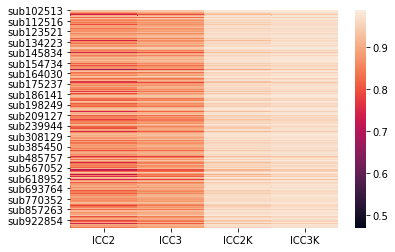

In [129]:
seaborn.heatmap(subwise_ICC)
plt.show()

In [130]:
subwise_ICC_min = []
subwise_ICC_max = []
subwise_ICC_mean = []
subwise_ICC_std = []

criteria = ['ICC2','ICC3','ICC2K','ICC3K']
for criterion in criteria:
    subwise_ICC_min.append(min(subwise_ICC[criterion]))
    subwise_ICC_max.append(max(subwise_ICC[criterion]))
    subwise_ICC_mean.append(np.mean(subwise_ICC[criterion]))
    subwise_ICC_std.append(np.std(subwise_ICC[criterion]))

In [131]:
subwise_ICC_stats = pd.DataFrame({'subjectwise_min':subwise_ICC_min,'subjectwise_max':subwise_ICC_max,'subjectwise_mean':subwise_ICC_mean,'subjectwise_std':subwise_ICC_std})

In [132]:
subwise_ICC_stats.index = criteria

In [133]:
subwise_ICC_stats

,subjectwise_min,subjectwise_max,subjectwise_mean,subjectwise_std
ICC2,0.470297,0.949830,0.859111,0.055205
ICC3,0.701309,0.951845,0.884214,0.036475
ICC2K,0.780288,0.986967,0.959737,0.019140
ICC3K,0.903770,0.987510,0.967961,0.011342


# Region-wise Intraclass Correlation

In [137]:
regwise_ICC2 = []
regwise_ICC3 = []
regwise_ICC2K = []
regwise_ICC3K = []

sub_IDs = sorted(list(all_Rscore[0].index))
subs = list(sorted(list(all_Rscore[0].index)*4))
runs = []
for tmp in list(itertools.repeat([1,2,3,4],810)):
    runs.extend(tmp)
        


In [139]:
for reg in list(all_Rscore[0].columns):    
    vectorized_Rscore = []    
    for sub in sub_IDs:
        for run in range(0,4):
            vectorized_Rscore.append(all_Rscore[run][reg].loc[sub])
    
    reg_df = pd.DataFrame({'sub':subs, 'run':runs, 'Rscore':vectorized_Rscore})
    
    icc = pg.intraclass_corr(data=reg_df, targets='sub', raters='run',ratings='Rscore')
    
    regwise_ICC2.append(icc['ICC'].loc[1])
    regwise_ICC3.append(icc['ICC'].loc[2])
    regwise_ICC2K.append(icc['ICC'].loc[4])
    regwise_ICC3K.append(icc['ICC'].loc[5])    

region 1 is done
region 2 is done
region 3 is done
region 4 is done
region 5 is done
region 6 is done
region 7 is done
region 8 is done
region 9 is done
region 10 is done
region 11 is done
region 12 is done
region 13 is done
region 14 is done
region 15 is done
region 16 is done
region 17 is done
region 18 is done
region 19 is done
region 20 is done
region 21 is done
region 22 is done
region 23 is done
region 24 is done
region 25 is done
region 26 is done
region 27 is done
region 28 is done
region 29 is done
region 30 is done
region 31 is done
region 32 is done
region 33 is done
region 34 is done
region 35 is done
region 36 is done
region 37 is done
region 38 is done
region 39 is done
region 40 is done
region 41 is done
region 42 is done
region 43 is done
region 44 is done
region 45 is done
region 46 is done
region 47 is done
region 48 is done
region 49 is done
region 50 is done
region 51 is done
region 52 is done
region 53 is done
region 54 is done
region 55 is done
region 56 is done
r

In [140]:
regwise_ICC = pd.DataFrame({'ICC2':regwise_ICC2,'ICC3':regwise_ICC3,'ICC2K':regwise_ICC2K,'ICC3K':regwise_ICC3K})

In [142]:
regwise_ICC.index = list(all_Rscore[0].columns)

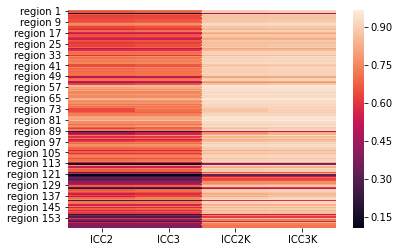

In [143]:
seaborn.heatmap(regwise_ICC)
plt.show()

In [144]:
regwise_ICC_min = []
regwise_ICC_max = []
regwise_ICC_mean = []
regwise_ICC_std = []

criteria = ['ICC2','ICC3','ICC2K','ICC3K']
for criterion in criteria:
    regwise_ICC_min.append(min(regwise_ICC[criterion]))
    regwise_ICC_max.append(max(regwise_ICC[criterion]))
    regwise_ICC_mean.append(np.mean(regwise_ICC[criterion]))
    regwise_ICC_std.append(np.std(regwise_ICC[criterion]))

In [145]:
regwise_ICC_stats = pd.DataFrame({'regionwise_min':regwise_ICC_min,'regionwise_max':regwise_ICC_max,'regionwise_mean':regwise_ICC_mean,'regionwise_std':regwise_ICC_std})

In [146]:
regwise_ICC_stats.index = criteria

In [148]:
regwise_ICC_stats

,regionwise_min,regionwise_max,regionwise_mean,regionwise_std
ICC2,0.106114,0.868664,0.622342,0.156190
ICC3,0.107329,0.868932,0.632159,0.157305
ICC2K,0.321961,0.963578,0.850500,0.112396
ICC3K,0.324750,0.963661,0.855215,0.112715


# Cronbach's Alpha

#### We will also investigate the concistency of results of all 4 runs by computing the Cronbach's Alpha

In [159]:
prod_sub_reg = sorted(list(itertools.product(all_Rscore[0].index,all_Rscore[0].columns)))

In [161]:
vectorized_Rscores = []
for run in range(0,4):
    vectorized_Rscore = []
    for (sub,reg) in prod_sub_reg:
        vectorized_Rscore.append(all_Rscore[run][reg].loc[sub])
    vectorized_Rscores.append(vectorized_Rscore)

In [163]:
df = pd.DataFrame({'run1':vectorized_Rscores[0],'run2':vectorized_Rscores[1],'run3':vectorized_Rscores[2],'run4':vectorized_Rscores[3]})

#### We use Spearman correlation here instead of Pearson correlation because it is more important to capture the similarity between ranks of different values instead of capturing the overall trend

In [169]:
pairwise_corrs = pairwise_corr(df, method='spearman', tail='one-sided',padjust='bonf')  

#### By the formula, Cronbach's alpha is $\alpha=\frac{k\bar{\rho}}{1+(k-1)\bar{\rho}}$ where $k$ is the number of runs in our case.

In [183]:
rho =np.mean(pairwise_corrs['r'])

In [184]:
alpha = 4*rho/(1+3*rho)

In [185]:
print("The normalized Cronbach's alpha is equal to {}".format(alpha))

The normalized Cronbach's alpha is equal to 0.9620001160022581


## Subject-wise Interclass Correlation

#### Here we compute all correlations between the runs (4 tuns in total so a total of 6 possible correlations) for both each subject and each region. We then compute for each subject or each region the min,max and mean among the 6 possible correlations.

In [17]:
from scipy.stats import pearsonr

In [26]:
sub_corr12 = [] # correlation on subject level between run1 and run2
sub_corr13 = [] # correlation on subject level between run1 and run3
sub_corr14 = [] # correlation on subject level between run1 and run4
sub_corr23 = [] # correlation on subject level between run2 and run3
sub_corr24 = [] # correlation on subject level between run2 and run4
sub_corr34 = [] # correlation on subject level between run3 and run4

In [27]:
for sub in sub_IDs:
    sub_corr12.append(pearsonr(all_Rscore[0].loc[sub],all_Rscore[1].loc[sub])[0])
    sub_corr13.append(pearsonr(all_Rscore[0].loc[sub],all_Rscore[2].loc[sub])[0])
    sub_corr14.append(pearsonr(all_Rscore[0].loc[sub],all_Rscore[3].loc[sub])[0])
    sub_corr23.append(pearsonr(all_Rscore[1].loc[sub],all_Rscore[2].loc[sub])[0])
    sub_corr24.append(pearsonr(all_Rscore[1].loc[sub],all_Rscore[3].loc[sub])[0])
    sub_corr34.append(pearsonr(all_Rscore[2].loc[sub],all_Rscore[3].loc[sub])[0])
    
sub_corr12 = pd.DataFrame(sub_corr12,index=sub_IDs,columns=['run1_vs_run2'])
sub_corr13 = pd.DataFrame(sub_corr13,index=sub_IDs,columns=['run1_vs_run3'])
sub_corr14 = pd.DataFrame(sub_corr14,index=sub_IDs,columns=['run1_vs_run4'])
sub_corr23 = pd.DataFrame(sub_corr23,index=sub_IDs,columns=['run2_vs_run3'])
sub_corr24 = pd.DataFrame(sub_corr24,index=sub_IDs,columns=['run2_vs_run4'])
sub_corr34 = pd.DataFrame(sub_corr34,index=sub_IDs,columns=['run3_vs_run4'])

In [42]:
sub_corr = pd.concat([sub_corr12,sub_corr13,sub_corr14,sub_corr23,sub_corr24,sub_corr34],axis=1,sort=True)

In [43]:
sub_corr['mean'] = sub_corr.mean(axis=1)
sub_corr['min'] = sub_corr.min(axis=1)
sub_corr['max'] = sub_corr.max(axis=1)

In [48]:
min_max_mean = sub_corr[['mean','min','max']]

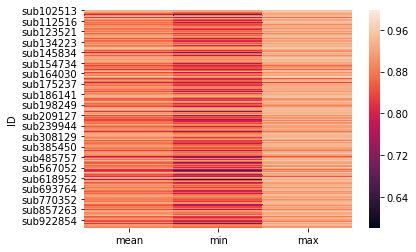

In [50]:
seaborn.heatmap(min_max_mean)
plt.show()

## Region-wise Interclass Correlation

In [59]:
reg_corr12 = [] # correlation on region level between run1 and run2
reg_corr13 = [] # correlation on region level between run1 and run3
reg_corr14 = [] # correlation on region level between run1 and run4
reg_corr23 = [] # correlation on region level between run2 and run3
reg_corr24 = [] # correlation on region level between run2 and run4
reg_corr34 = [] # correlation on region level between run3 and run4

In [60]:
for reg in all_Rscore[0].columns:
    reg_corr12.append(pearsonr(all_Rscore[0][reg],all_Rscore[1][reg])[0])
    reg_corr13.append(pearsonr(all_Rscore[0][reg],all_Rscore[2][reg])[0])
    reg_corr14.append(pearsonr(all_Rscore[0][reg],all_Rscore[3][reg])[0])
    reg_corr23.append(pearsonr(all_Rscore[1][reg],all_Rscore[2][reg])[0])
    reg_corr24.append(pearsonr(all_Rscore[1][reg],all_Rscore[3][reg])[0])
    reg_corr34.append(pearsonr(all_Rscore[2][reg],all_Rscore[3][reg])[0])
    
reg_corr12 = pd.DataFrame(reg_corr12,index=all_Rscore[0].columns,columns=['run1_vs_run2'])
reg_corr13 = pd.DataFrame(reg_corr13,index=all_Rscore[0].columns,columns=['run1_vs_run3'])
reg_corr14 = pd.DataFrame(reg_corr14,index=all_Rscore[0].columns,columns=['run1_vs_run4'])
reg_corr23 = pd.DataFrame(reg_corr23,index=all_Rscore[0].columns,columns=['run2_vs_run3'])
reg_corr24 = pd.DataFrame(reg_corr24,index=all_Rscore[0].columns,columns=['run2_vs_run4'])
reg_corr34 = pd.DataFrame(reg_corr34,index=all_Rscore[0].columns,columns=['run3_vs_run4'])

In [67]:
reg_corr = pd.concat([reg_corr12,reg_corr13,reg_corr14,reg_corr23,reg_corr24,reg_corr34],axis=1)

In [68]:
reg_corr

,run1_vs_run2,run1_vs_run3,run1_vs_run4,run2_vs_run3,run2_vs_run4,run3_vs_run4
region 1,0.769513,0.704310,0.670732,0.707832,0.682962,0.784697
region 2,0.705634,0.637400,0.660190,0.663029,0.613808,0.744284
region 3,0.192264,0.134224,0.186951,0.133739,0.160643,0.134756
region 4,0.741322,0.633643,0.639581,0.657397,0.644261,0.760373
region 5,0.709193,0.585483,0.583917,0.605885,0.565667,0.711533
...,...,...,...,...,...,...
region 156,0.233592,0.313392,0.216255,0.142887,0.189222,0.356176
region 157,0.582153,0.575724,0.512919,0.509129,0.599532,0.600902
region 158,0.380356,0.444120,0.380540,0.371887,0.429542,0.457291
region 159,0.415993,0.332153,0.358553,0.352620,0.354634,0.511403


In [69]:
reg_corr['min'] = reg_corr.min(axis=1)
reg_corr['max'] = reg_corr.max(axis=1)
reg_corr['mean'] = reg_corr.mean(axis=1)

In [70]:
reg_corr

,run1_vs_run2,run1_vs_run3,run1_vs_run4,run2_vs_run3,run2_vs_run4,run3_vs_run4,min,max,mean
region 1,0.769513,0.704310,0.670732,0.707832,0.682962,0.784697,0.670732,0.784697,0.721934
region 2,0.705634,0.637400,0.660190,0.663029,0.613808,0.744284,0.613808,0.744284,0.672805
region 3,0.192264,0.134224,0.186951,0.133739,0.160643,0.134756,0.133739,0.192264,0.158572
region 4,0.741322,0.633643,0.639581,0.657397,0.644261,0.760373,0.633643,0.760373,0.683824
region 5,0.709193,0.585483,0.583917,0.605885,0.565667,0.711533,0.565667,0.711533,0.629860
...,...,...,...,...,...,...,...,...,...
region 156,0.233592,0.313392,0.216255,0.142887,0.189222,0.356176,0.142887,0.356176,0.243823
region 157,0.582153,0.575724,0.512919,0.509129,0.599532,0.600902,0.509129,0.600902,0.561299
region 158,0.380356,0.444120,0.380540,0.371887,0.429542,0.457291,0.371887,0.457291,0.411614
region 159,0.415993,0.332153,0.358553,0.352620,0.354634,0.511403,0.332153,0.511403,0.396114


In [71]:
min_max_mean = reg_corr[['mean','min','max']]

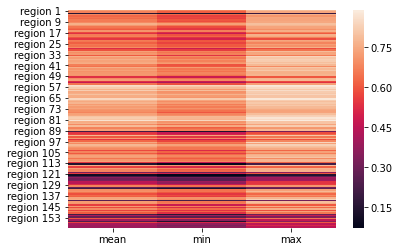

In [72]:
seaborn.heatmap(min_max_mean)
plt.show()